In [1]:
import os
import cv2
import time
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision import models
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from pathlib import Path
from torch.autograd import Variable
from PIL import Image
%matplotlib inline

In [2]:
data_path = Path(r'/media/dmitriy/Disk/Downloads/leapgestds/leapGestRecog/')

In [3]:
tmp_ds = ImageFolder(data_path / '00')
classes_names = tmp_ds.classes
classes_names

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [4]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3),
                         tt.Resize([128, 128]),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor(),
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])

In [5]:
import re


def gest_label_encoding(gest):
    code = re.findall('^\d*', gest)[0]
    return int(code)-1


def make_df_from_files(parent_dir_path=data_path):
    result = list()
    for person in os.listdir(parent_dir_path):
        person_path = parent_dir_path.joinpath(person)
        for gest in os.listdir(person_path):
            gest_path = person_path.joinpath(gest)
            for img in os.listdir(gest_path):
                result.append([img, gest_path.joinpath(img), gest_label_encoding(gest), person])
    return result

In [6]:
gest_df = pd.DataFrame(make_df_from_files(), columns=('img', 'path', 'gest', 'person'))
gest_df.head(5)

,img,path,gest,person
0,frame_06_07_0057.png,/media/dmitriy/Disk/Downloads/leapgestds/leapG...,6,06
1,frame_06_07_0045.png,/media/dmitriy/Disk/Downloads/leapgestds/leapG...,6,06
2,frame_06_07_0162.png,/media/dmitriy/Disk/Downloads/leapgestds/leapG...,6,06
3,frame_06_07_0005.png,/media/dmitriy/Disk/Downloads/leapgestds/leapG...,6,06
4,frame_06_07_0190.png,/media/dmitriy/Disk/Downloads/leapgestds/leapG...,6,06


In [7]:
class LeapGests(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing  
        self.image_paths = self.data.iloc[:, 1]
        self.image_gest = self.data.iloc[:, 2]
        self.data_len = len(self.data.index)
        

    def __len__(self):
        return self.data_len
        

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        if self.preprocessing is not None:
            img = self.preprocessing(img)
        gest = self.image_gest[idx]
        return img, gest

In [8]:
batch_size = 64

In [9]:
train_dataset = LeapGests(gest_df, train_tfms)
valid_dataset = LeapGests(gest_df, test_tfms)

In [10]:
torch.manual_seed(1)
val_split = 0.25
split = int(len(gest_df) * val_split)
indices = torch.randperm(len(gest_df))
train_ds = torch.utils.data.Subset(train_dataset, indices[split:])
test_ds = torch.utils.data.Subset(valid_dataset, indices[:split])
len(train_ds), len(test_ds)

(15000, 5000)

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=1)

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


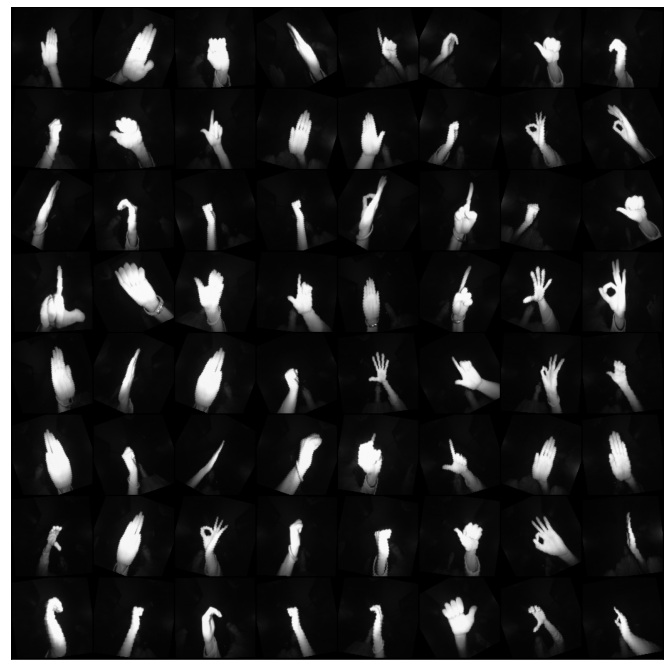

In [13]:
show_batch(train_loader)

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device


    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)


    def __len__(self):
        return len(self.dl)

In [15]:
device = get_default_device()

In [16]:
train_dl = DeviceDataLoader(train_loader, device)
test_dl = DeviceDataLoader(valid_loader, device)

In [17]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

/home/dmitriy/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dmitriy/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
for param in list(resnet.parameters())[:]:
    param.requires_grad = False

In [19]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=10)
resnet.fc = fc
summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)  
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [21]:
torch.cuda.empty_cache()
history = []
epochs = 30
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), max_lr, weight_decay=weight_decay)

In [22]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

30 epochs, 313 total_steps per epoch


In [23]:
epoch_losses = []
for epoch in range(epochs):
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = resnet(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  0.6620727022425436
Epoch 2, loss:  0.35331076350265417
Epoch 3, loss:  0.2878749133727421
Epoch 4, loss:  0.266697158614477
Epoch 5, loss:  0.24823833256959915
Epoch 6, loss:  0.23273286668542095
Epoch 7, loss:  0.21809620162644705
Epoch 8, loss:  0.20357892098137365
Epoch 9, loss:  0.19328204897074655
Epoch 10, loss:  0.19562360249197902
Epoch 11, loss:  0.17886520979313042
Epoch 12, loss:  0.1753038010015465
Epoch 13, loss:  0.16404154204046384
Epoch 14, loss:  0.161549288065384
Epoch 15, loss:  0.15904327743826582
Epoch 16, loss:  0.15962823521429167
Epoch 17, loss:  0.15203342908106673
Epoch 18, loss:  0.15420394342618818
Epoch 19, loss:  0.14951243612189263
Epoch 20, loss:  0.1469565333364109
Epoch 21, loss:  0.1448981623989515
Epoch 22, loss:  0.13818488312891117
Epoch 23, loss:  0.13116591987899318
Epoch 24, loss:  0.12900965435269732
Epoch 25, loss:  0.13619734737248465
Epoch 26, loss:  0.13266116293807761
Epoch 27, loss:  0.129218244127715
Epoch 28, loss:  0.12

Text(0.5, 1.0, 'losses vs. No. of epochs')

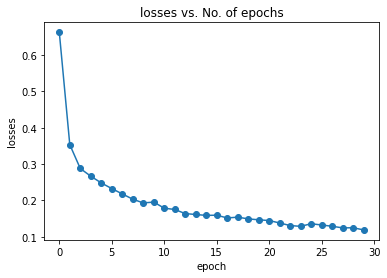

In [24]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, marker='o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [25]:
torch.save(resnet, r'/media/dmitriy/Disk/Downloads/leapgestds/detection_model.pth')

In [26]:
resnet = torch.load(r'/media/dmitriy/Disk/Downloads/leapgestds/detection_model.pth')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

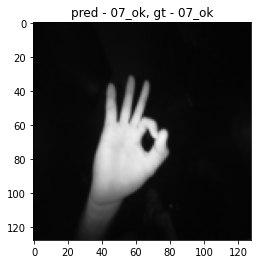

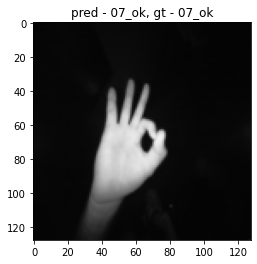

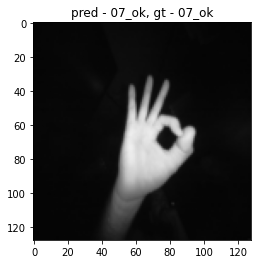

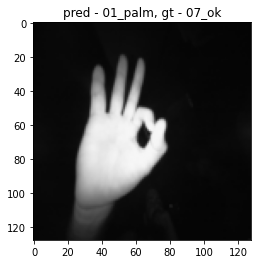

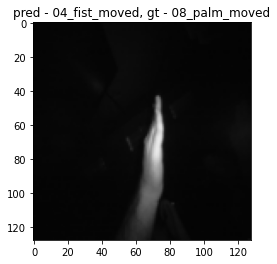

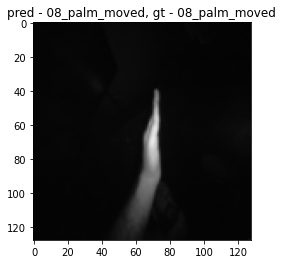

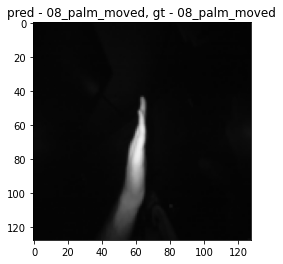

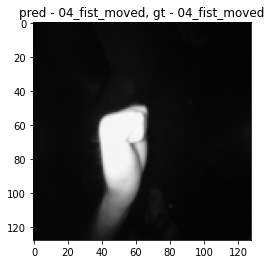

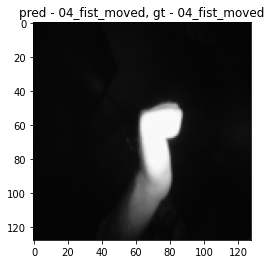

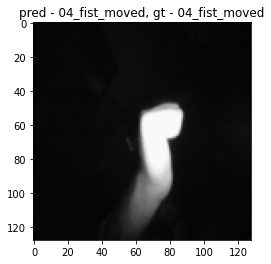

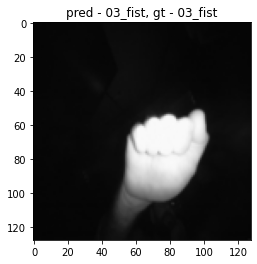

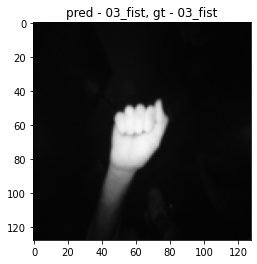

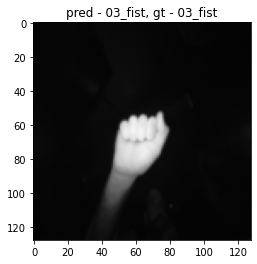

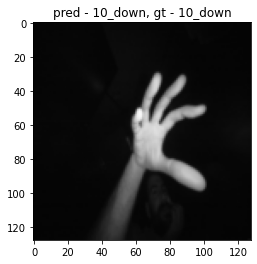

In [27]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        plt.title(f'pred - {classes_names[outputs[0].argmax()]}, gt - {classes_names[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>15:
            break

In [28]:
my_photos_path = r'/media/dmitriy/Disk/Downloads/leapgestds/my_data/'
photos_names = os.listdir(my_photos_path)
photos_names = [i for i in photos_names if '.JPG' in i]
for photo in photos_names:
    img = cv2.imread(os.path.join(my_photos_path, photo))
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    ret, thresh = cv2.threshold(imgray, 80, 255, cv2.THRESH_BINARY)
    cv2.imwrite(os.path.join(my_photos_path, r'grayscale_images', f't_{photo}'), thresh)
    # plt.imshow(thresh)
    # plt.show()

In [29]:
gr_path = os.path.join(my_photos_path, r'grayscale_images')
imgs = os.listdir(gr_path)
paths = [os.path.join(gr_path, i) for i in imgs]
gest = {'img': imgs, 
        'path': paths, 
        'gest': [5, 4, 7, 0, 6]}
df = pd.DataFrame(gest)
df

,img,path,gest
0,t_IMG_7023.JPG,/media/dmitriy/Disk/Downloads/leapgestds/my_da...,5
1,t_IMG_7025.JPG,/media/dmitriy/Disk/Downloads/leapgestds/my_da...,4
2,t_IMG_7022.JPG,/media/dmitriy/Disk/Downloads/leapgestds/my_da...,7
3,t_IMG_7026.JPG,/media/dmitriy/Disk/Downloads/leapgestds/my_da...,0
4,t_IMG_7024.JPG,/media/dmitriy/Disk/Downloads/leapgestds/my_da...,6


In [30]:
test_dataset = LeapGests(df, test_tfms)

In [31]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=1)

In [32]:
dl = DeviceDataLoader(test_loader, device)

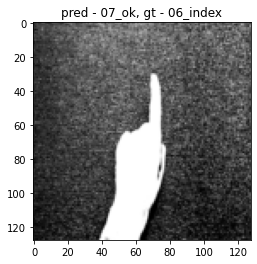

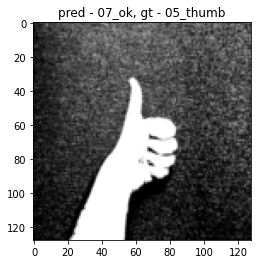

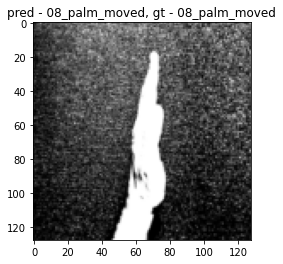

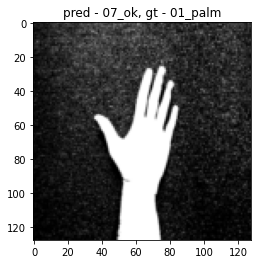

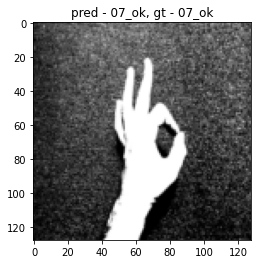

In [33]:
with torch.no_grad():
    for i, data in enumerate(dl):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet(images)
        plt.title(f'pred - {classes_names[outputs[0].argmax()]}, gt - {classes_names[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break   